In [60]:
import ray

import torch

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()


# 数据清洗与可视化

**任务1**

In [61]:
import os
from torch.utils.data import Dataset
from PIL import Image

class PizzaOrNotDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, device="cpu"):
        self.positive_idxs = os.listdir(os.path.join(root_dir, "pizza"))
        self.negative_idxs = os.listdir(os.path.join(root_dir, "not_pizza"))
        self.root_dir = root_dir
        self.transform = transform
        self.device = device

    def __len__(self):
        return self.n_positive + self.n_negative
    
    def __getitem__(self, idx: int):
        if idx < self.n_positive:
            img_name = os.path.join(self.root_dir, "pizza", self.positive_idxs[idx])
            label = 1
        else:
            img_name = os.path.join(self.root_dir, "not_pizza", self.negative_idxs[idx - self.n_positive])
            label = 0

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)
            
        return image.to(self.device), torch.tensor(label).to(self.device)

    @property
    def n_positive(self):
        return len(self.positive_idxs)
    @property
    def n_negative(self):
        return len(self.negative_idxs)

In [62]:
from torchvision.transforms import Compose, ToTensor, Resize

device = "cuda" if torch.cuda.is_available() else "cpu"
pizza_or_not_dataset = PizzaOrNotDataset(
    root_dir="D:\\MLChem\\Github\\Mechine-Learning-and-its-Applications-in-Chemistry\\Labs\\Lab3\\pizza_not_pizza",
    transform=Compose([ToTensor(), Resize((128, 128))]),
    device=device
)
X_demo, y_true_demo = pizza_or_not_dataset[0]
X_demo.shape, y_true_demo

(torch.Size([3, 128, 128]), tensor(1, device='cuda:0'))

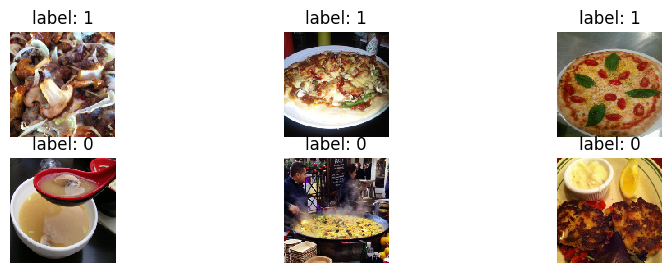

In [63]:
from typing import List
from matplotlib import pyplot as plt

def visualize_data(samples: List, n_rows: int):
    plt.figure(figsize=(10, 3))
    n_samples = len(samples)
    for i, sample in enumerate(samples):
        img, label = sample
        plt.subplot(n_rows, n_samples // n_rows, i + 1)
        plt.imshow(img.permute((1, 2, 0)).cpu(), interpolation="none")
        plt.title(f"label: {int(label.item())}")
        plt.axis("off")
    plt.show()

visualize_data(samples=[pizza_or_not_dataset[i] for i in (300, 600, 900, 1200, 1500, 1800)], n_rows=2)

# 模型的搭建

**任务2**

In [64]:
from torch import nn
from torch.nn import functional as F

class ConvModule(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=kernel_size, dilation=1, padding="same")
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=kernel_size, dilation=3, padding="same")
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, X):
        X = self.pooling1(F.relu(self.conv1(X)))
        X = self.pooling2(F.relu(self.conv2(X)))
        return X

In [65]:
class PizzaOrNotModel(nn.Module):
    def __init__(self, kernel_size=3, num_hiddens=1024):
        super().__init__()
        self.conv = ConvModule(kernel_size=kernel_size)
        self.fcnn = nn.Linear(16 * 32 * 32, num_hiddens)
        self.fcnn_output = nn.Linear(num_hiddens, 1)
        self.activation = nn.Sigmoid()

    def forward(self, X):
        X = self.conv(X).reshape((X.shape[0], -1))
        X = F.relu(self.fcnn(X))
        X = self.fcnn_output(X)
        return self.activation(X).squeeze()

In [66]:
pizza_or_not_model = PizzaOrNotModel().to(device)
pizza_or_not_model(X_demo.unsqueeze(0))

tensor(0.4869, device='cuda:0', grad_fn=<SqueezeBackward0>)

# 超参数对模型训练的影响: 试验与优化

**任务3**

In [67]:
def train_model_epoch(model, dataloader, optimizer, criterion, log=True):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    for i, (X, y_true) in enumerate(dataloader):
        optimizer.zero_grad()
        y_prob = model(X).squeeze()
        loss = criterion(y_prob, y_true.float())
        loss.backward()
        optimizer.step()
        train_loss += loss
        if log:
            if i % 100 == 0:
                print(f"Batch No. {i}, loss = {loss.item()}")
    return (train_loss / num_batches).item()

In [121]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion, threshold: float=0.5):
    model.eval()
    loss, tp, fp, tn, fn = 0, 0, 0, 0, 0
    num_batches = len(dataloader)
    for X, y_true in dataloader:
        y_prob = model(X).squeeze()
        y_true = y_true.float()
        loss += criterion(y_prob, y_true)
        y_pred = (y_prob > threshold)
        for idx in range(y_true.shape[0]):
            true, pred = int(y_true[idx].item()), int(y_pred[idx].item())
            if (true, pred) == (1, 1):
                tp += 1
            elif (true, pred) == (1, 0):
                fn += 1
            elif (true, pred) == (0, 1):
                fp += 1
            else:
                tn += 1
    return (loss / num_batches).item(), tn, fp, fn, tp

## 搭建训练组件

In [69]:
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(
    train_subset, val_subset, config: Dict, num_epochs: int=5,
    device="cpu", log=True, save=False
) -> Tuple[List[float], List[float], List[float]]:
    
    model = PizzaOrNotModel(kernel_size=config["kernel_size"], num_hiddens=config["num_hiddens"]).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=0.5)

    train_loader = DataLoader(train_subset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=config["batch_size"], shuffle=False)

    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        train_loss = train_model_epoch(model, train_loader, optimizer, criterion, log)
        train_losses.append(train_loss)

        train_loss, tn, fp, fn, tp = evaluate_model(model, train_loader, criterion)
        val_loss, tn2, fp2, fn2, tp2 = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)

        train_accuracy = (tp + tn) / (tp + tn + fp + fn)
        val_accuracy = (tp2 + tn2) / (tp2 + tn2 + fp2 + fn2)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if log:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save:
        torch.save(model.state_dict(), "model.pth")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [70]:
torch.cuda.is_available()

True

In [73]:
from torch.utils.data import random_split

config = {
    "kernel_size": 3, "num_hiddens": 1024,
    "batch_size": 8, "lr": 0.01,
}
train_subset, test_subset = random_split(pizza_or_not_dataset, [0.9, 0.1])
train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=True, device="cuda" if torch.cuda.is_available() else "cpu")

Batch No. 0, loss = 0.6933645009994507
Batch No. 100, loss = 0.6060442328453064
Batch No. 200, loss = 0.7557298541069031
Epoch [1/5], Train Loss: 0.6124, Train Accuracy: 0.6898, Val Loss: 0.6320, Val Accuracy: 0.6633
Batch No. 0, loss = 0.6594429016113281
Batch No. 100, loss = 0.46270400285720825
Batch No. 200, loss = 0.8603681325912476
Epoch [2/5], Train Loss: 0.6016, Train Accuracy: 0.6910, Val Loss: 0.6338, Val Accuracy: 0.6531
Batch No. 0, loss = 0.6737682819366455
Batch No. 100, loss = 0.39534035325050354
Batch No. 200, loss = 0.4006116986274719
Epoch [3/5], Train Loss: 0.6438, Train Accuracy: 0.6356, Val Loss: 0.6946, Val Accuracy: 0.6122
Batch No. 0, loss = 0.7775061130523682
Batch No. 100, loss = 0.6954934597015381
Batch No. 200, loss = 0.5300257802009583
Epoch [4/5], Train Loss: 0.5665, Train Accuracy: 0.7119, Val Loss: 0.6331, Val Accuracy: 0.6224
Batch No. 0, loss = 0.454986035823822
Batch No. 100, loss = 0.2860275208950043
Batch No. 200, loss = 0.4258384704589844
Epoch [5/5

## 超参数数值的试验

In [74]:
def visualize_learning(
    train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection,
    mode="tune", labels=None
):
    if mode == "tune":
        fig, axes = plt.subplots(2, 2, layout="constrained")
        for label, train_losses in zip(labels, train_losses_collection):
            axes[0][0].plot(train_losses, marker="^", label=label)
        axes[0][0].set_title("Train losses")
        axes[0][0].set_xlabel("Epoch No.")
        axes[0][0].set_ylabel("Loss")
        axes[0][0].legend()
        for label, val_losses in zip(labels, val_losses_collection):
            axes[0][1].plot(val_losses, marker="^", label=label)
        axes[0][1].set_title("Validation losses")
        axes[0][1].set_xlabel("Epoch No.")
        axes[0][1].set_ylabel("Loss")
        axes[0][1].legend()
        for label, train_accs in zip(labels, train_accs_collection):
            axes[1][0].plot(train_accs, marker="^", label=label)
        axes[1][0].set_title("Train accuracies")
        axes[1][0].set_xlabel("Epoch No.")
        axes[1][0].set_ylabel("Accuracy")
        axes[1][0].legend()
        for label, val_accs in zip(labels, val_accs_collection):
            axes[1][1].plot(val_accs, marker="^", label=label)
        axes[1][1].set_title("Validation accuracies")
        axes[1][1].set_xlabel("Epoch No.")
        axes[1][1].set_ylabel("Accuracy")
        axes[1][1].legend()
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(train_losses_collection, label="train")
        ax1.plot(val_losses_collection, label="test")
        ax1.set_title("Losses on train/test dataset")
        ax1.set_xlabel("Epoch No.")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax2.plot(train_accs_collection, label="train")
        ax2.plot(val_accs_collection, label="test")
        ax2.set_title("Accuracies on train/test dataset")
        ax2.set_xlabel("Epoch No.")
        ax2.set_ylabel("Accuracy")
        ax2.legend()

## 任务4.1

Batch No. 0, loss = 0.6938802003860474
Batch No. 100, loss = 0.7093977928161621
Batch No. 200, loss = 0.6877409219741821
Epoch [1/5], Train Loss: 0.6925, Train Accuracy: 0.5226, Val Loss: 0.6929, Val Accuracy: 0.5000
Batch No. 0, loss = 0.6925137639045715
Batch No. 100, loss = 0.7074264287948608
Batch No. 200, loss = 0.6833840608596802
Epoch [2/5], Train Loss: 0.6923, Train Accuracy: 0.5333, Val Loss: 0.6924, Val Accuracy: 0.5357
Batch No. 0, loss = 0.6938982009887695
Batch No. 100, loss = 0.699805736541748
Batch No. 200, loss = 0.6788274645805359
Epoch [3/5], Train Loss: 0.6916, Train Accuracy: 0.4989, Val Loss: 0.6915, Val Accuracy: 0.5204
Batch No. 0, loss = 0.6982681751251221
Batch No. 100, loss = 0.696841835975647
Batch No. 200, loss = 0.6847473978996277
Epoch [4/5], Train Loss: 0.6935, Train Accuracy: 0.5023, Val Loss: 0.6978, Val Accuracy: 0.4796
Batch No. 0, loss = 0.6783923506736755
Batch No. 100, loss = 0.6712242364883423
Batch No. 200, loss = 0.6714309453964233
Epoch [5/5], 

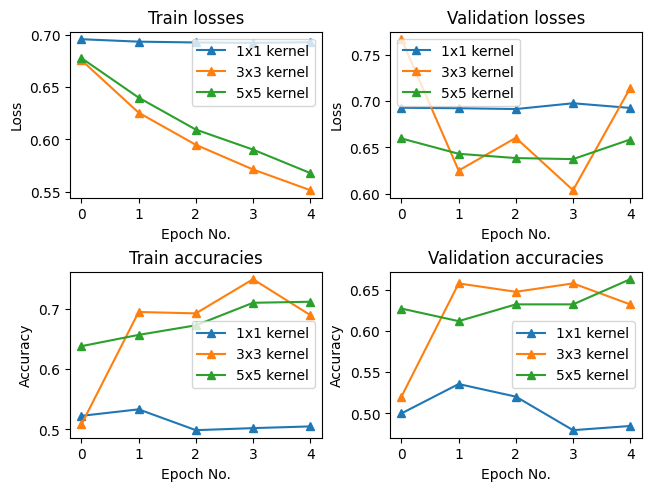

In [76]:
kernel_size_collection = (1, 3, 5)
labels = []
train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection = [], [], [], []

for kernel_size in kernel_size_collection:
    config["kernel_size"] = kernel_size
    labels.append(f"{kernel_size}x{kernel_size} kernel")
    train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=True, device=device)
    train_losses_collection.append(train_losses)
    train_accs_collection.append(train_accs)
    val_losses_collection.append(val_losses)
    val_accs_collection.append(val_accs)
    print(f"Kernel size: {kernel_size}x{kernel_size}, {val_losses}")

visualize_learning(
    train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection,
    labels=labels
)

### 卷积核

在卷积神经网络（CNN）中，卷积核（或过滤器）的大小对模型的性能有直接影响。这是因为卷积核定义了在处理图像时能捕获的空间信息的局部区域大小。

1. **空间信息的提取能力**:
   - **1x1卷积核**: 它通常用于调整网络层间的通道数，因为它只作用于单个像素及其对应的所有通道。它不会捕获空间信息，而是允许网络学习跨通道的特征组合。
   - **3x3卷积核**: 这是最常用的卷积核大小之一，因为它在保持计算效率的同时能够有效捕获局部特征。3x3卷积可以覆盖3x3像素区域的空间信息，允许网络检测例如边缘、角点等特征。
   - **5x5卷积核**: 它涵盖了更大的空间范围，可以捕获更宽广的局部特征。这使得网络能够更好地理解图像中的空间层次结构，但代价是增加了计算复杂度。

2. **模型参数的规模**:
   - 卷积核的大小直接影响模型参数的数量。具体来说，参数数量是卷积核大小乘以输入通道数再乘以输出通道数。例如，如果输入和输出通道数相同，5x5卷积核将有比3x3卷积核多出（5x5）/（3x3）=25/9倍的参数。
   - **1x1卷积核**: 参数最少，因为每个卷积核只有一个参数。
   - **3x3卷积核**: 参数数量适中，是1x1卷积核的9倍。
   - **5x5卷积核**: 参数最多，是1x1卷积核的25倍。

在图像中，我们可以看到不同卷积核大小对训练和验证损失及准确率的影响。较大的卷积核可能会导致训练更慢，也可能导致过拟合，特别是当可用的训练数据较少时。相比之下，3x3卷积核在减少模型复杂度和参数数量方面更好，而且也在参数优化的方面最为有效。

## 任务4.2

Batch No. 0, loss = 0.6907497644424438
Batch No. 100, loss = 0.6927433013916016
Batch No. 200, loss = 0.6927982568740845
Epoch [1/5], Train Loss: 0.6912, Train Accuracy: 0.5955, Val Loss: 0.6913, Val Accuracy: 0.6071
Batch No. 0, loss = 0.6931286454200745
Batch No. 100, loss = 0.6861162781715393
Batch No. 200, loss = 0.6868338584899902
Epoch [2/5], Train Loss: 0.6886, Train Accuracy: 0.6085, Val Loss: 0.6896, Val Accuracy: 0.5969
Batch No. 0, loss = 0.6993452906608582
Batch No. 100, loss = 0.6754888296127319
Batch No. 200, loss = 0.6831372380256653
Epoch [3/5], Train Loss: 0.6847, Train Accuracy: 0.6124, Val Loss: 0.6866, Val Accuracy: 0.6020
Batch No. 0, loss = 0.6994959115982056
Batch No. 100, loss = 0.6856831312179565
Batch No. 200, loss = 0.6783567667007446
Epoch [4/5], Train Loss: 0.6769, Train Accuracy: 0.6198, Val Loss: 0.6809, Val Accuracy: 0.5918
Batch No. 0, loss = 0.6319496631622314
Batch No. 100, loss = 0.6535925269126892
Batch No. 200, loss = 0.6828826665878296
Epoch [5/5]

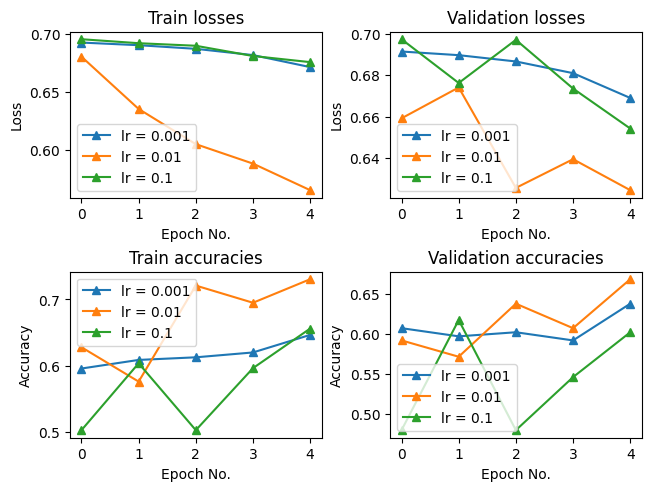

In [77]:
config["batch_size"] = 8
lr_collection = (10 ** n for n in (-3, -2, -1))
labels = []
train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection = [], [], [], []

for lr in lr_collection:
    config["lr"] = lr
    train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=True, device=device)
    labels.append(f"lr = {lr}")
    train_losses_collection.append(train_losses)
    train_accs_collection.append(train_accs)
    val_losses_collection.append(val_losses)
    val_accs_collection.append(val_accs)

visualize_learning(
    train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection,
    labels=labels
)

### 学习率

学习率（`lr`）是神经网络训练中最重要的超参数之一，它决定了模型参数在每次梯度下降时更新的幅度。根据测试结果，不同的学习率会对模型的性能和训练过程产生显著不同的影响：

1. **学习率为 0.001**：
   - 这是一个相对较小的学习率，通常用于保守地调整模型参数。小学习率的主要优点是能够使模型训练更稳定，降低模型在训练过程中发生震荡的风险。
   - 然而，过小的学习率可能导致模型收敛速度变慢，从而需要更多的训练迭代次数。此外，在某些情况下，过小的学习率可能导致模型陷入局部最优解，而非全局最优解。

2. **学习率为 0.01**：
   - 这个学习率处于中等水平，通常被认为是较好的起始点。中等学习率可以在保证相对稳定的学习过程的同时，保持较快的收敛速度。
   - 在许多情况下，0.01 的学习率可以提供良好的平衡，使模型能够有效地收敛，同时避免过慢的训练过程或过早陷入局部最优解。

3. **学习率为 0.1**：
   - 这是一个较高的学习率，它使得模型的参数在每次更新时都会发生较大的调整。高学习率的主要优点是可以加快模型的收敛速度，特别是在模型开始阶段，离最优解还很远的情况下。
   - 然而，过高的学习率可能导致模型训练过程中出现不稳定性，表现为损失函数震荡严重或甚至发散。此外，高学习率有时会使模型跳过最优解，从而影响最终的性能。

总结来说，选择合适的学习率是实现有效模型训练的关键。太小的学习率可能导致训练过程缓慢和陷入局部最优，而太大的学习率可能导致训练不稳定和模型性能不佳。通常，在实际应用中会通过实验或使用如学习率衰减、自适应学习率优化算法等策略来找到合适的学习率。

# 超参数的组合优化

**任务5**

In [78]:
from sklearn.model_selection import KFold
from ray import train
import ray.train.torch

n_splits = 5
splits = list(KFold(n_splits=n_splits, shuffle=True, random_state=42).split(train_subset))

def trainable(config):
    ray.train.torch.enable_reproducibility()
    
    total_val_loss, total_val_accuracy = 0, 0
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for train_idx, val_idx in splits:
        train_fold = torch.utils.data.Subset(train_subset, train_idx)
        val_fold = torch.utils.data.Subset(train_subset, val_idx)

        _, _, val_losses, val_accuracies = train_model(
            train_fold, val_fold, config, num_epochs=5, device=device, log=False
        )


        total_val_loss += val_losses[-1]
        total_val_accuracy += val_accuracies[-1]

    avg_val_loss = total_val_loss / n_splits
    avg_val_accuracy = total_val_accuracy / n_splits
    
    ray.train.report({"val_loss": avg_val_loss, "val_acc": avg_val_accuracy})

from ray import tune
from ray.tune.schedulers import ASHAScheduler

scheduler = ASHAScheduler(max_t=10, grace_period=5)

tune_config = tune.TuneConfig(
    metric="val_loss", mode="min",
    scheduler=scheduler,
    num_samples=6,
)

param_space = {
    "lr": tune.loguniform(1e-2, 1e-1),
    "num_hiddens": tune.choice([512, 1024]),
    "kernel_size": tune.choice([3, 5]),
    "batch_size": tune.choice([8, 16, 32])
}

tuner = tune.Tuner(
    trainable=tune.with_resources(
        tune.with_parameters(trainable),
        # resources={"cpu": 2, "gpu": 0}
        resources={"cpu": 15, "gpu": 1}
    ),
    tune_config=tune_config,
    param_space=param_space
)

results = tuner.fit()

2023-12-09 15:52:48,923	INFO tune.py:1144 -- Total run time: 4125.76 seconds (4125.68 seconds for the tuning loop).


In [79]:
best_result = results.get_best_result("val_loss", "min")
best_result.config

{'lr': 0.014860427589970276,
 'num_hiddens': 1024,
 'kernel_size': 3,
 'batch_size': 16}

# 模型训练与预测

**任务6**

In [80]:
train_losses, train_accs, test_losses, test_accs = train_model(
    train_subset, test_subset, config=best_result.config, num_epochs=10,
    log=True, save=True, device=device
)

Batch No. 0, loss = 0.6933424472808838
Batch No. 100, loss = 0.6701034307479858
Epoch [1/10], Train Loss: 0.6519, Train Accuracy: 0.6192, Val Loss: 0.6599, Val Accuracy: 0.6224
Batch No. 0, loss = 0.6720321178436279
Batch No. 100, loss = 0.6688493490219116
Epoch [2/10], Train Loss: 0.6039, Train Accuracy: 0.6768, Val Loss: 0.6323, Val Accuracy: 0.6378
Batch No. 0, loss = 0.674492597579956
Batch No. 100, loss = 0.6647148132324219
Epoch [3/10], Train Loss: 0.6416, Train Accuracy: 0.6452, Val Loss: 0.6951, Val Accuracy: 0.6122
Batch No. 0, loss = 0.5798922777175903
Batch No. 100, loss = 0.4349372982978821
Epoch [4/10], Train Loss: 0.5932, Train Accuracy: 0.6644, Val Loss: 0.6459, Val Accuracy: 0.6276
Batch No. 0, loss = 0.3777056336402893
Batch No. 100, loss = 0.44208845496177673
Epoch [5/10], Train Loss: 0.6054, Train Accuracy: 0.6520, Val Loss: 0.6709, Val Accuracy: 0.5918
Batch No. 0, loss = 0.7216331958770752
Batch No. 100, loss = 0.37064239382743835
Epoch [6/10], Train Loss: 0.5278, 

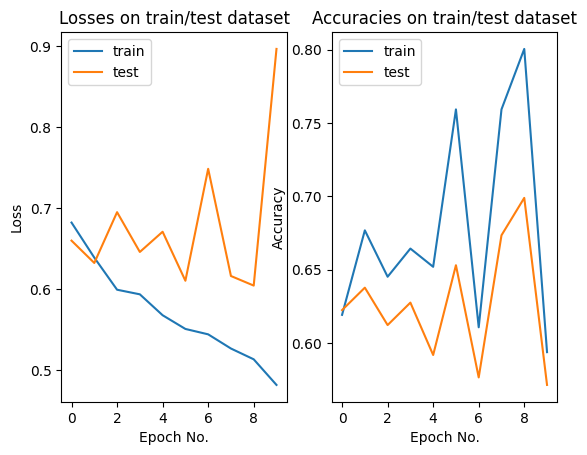

In [81]:
visualize_learning(train_losses, train_accs, test_losses, test_accs, mode="train")

In [131]:
def report_metrics(tn, fp, fn, tp):
    return {
        "accuracy": (tn + tp) / (tn + fp + fn + tp),
        "precision": tp / (tp + fp),
        "recall": tp / (tp + fn),
        "f1": 2 * tp / (2 * tp + fp + fn)
    }

之前的`evaluate_model`函数在运行保存后加在的模型会报错，因此我重新编写了`evaluate_model`函数以避免报错。

In [133]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion, threshold: float=0.5):
    model.eval()
    loss, tp, fp, tn, fn = 0, 0, 0, 0, 0
    num_batches = len(dataloader)
    for X, y_true in dataloader:
        y_prob = model(X).squeeze()
        y_true = y_true.float().squeeze()
        loss += criterion(y_prob, y_true)
        y_pred = (y_prob > threshold)
        true, pred = int(y_true.item()), int(y_pred.item())
        if (true, pred) == (1, 1):
            tp += 1
        elif (true, pred) == (1, 0):
            fn += 1
        elif (true, pred) == (0, 1):
            fp += 1
        else:
            tn += 1
    return (loss / num_batches).item(), tn, fp, fn, tp

In [134]:
model = PizzaOrNotModel(
    kernel_size=best_result.config["kernel_size"],
    num_hiddens=best_result.config["num_hiddens"],
).to(device)
model.load_state_dict(torch.load("model.pth"))
_, tn, fp, fn, tp = evaluate_model(model, DataLoader(train_subset), criterion=nn.BCELoss())


In [132]:
report_metrics(tn, fp, fn, tp)

{'accuracy': 0.5937853107344633,
 'precision': 0.5512658227848102,
 'recall': 0.9886492622020431,
 'f1': 0.707842340511987}